In [1]:
## This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
! pip install diffusers accelerate transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 24.5 MB/s eta 0:00:00


In [3]:
import torch 
import torch.nn as nn 
from torchvision.utils import make_grid 
import numpy as np 
from torch.utils.data import DataLoader
import torch.nn.functional as F 
from torchvision import datasets, transforms
import diffusers 
from diffusers import DDPMScheduler, UNet2DModel, DDPMPipeline
from PIL import Image
from datasets import load_dataset
import matplotlib.pyplot as plt 


2024-08-12 04:29:07.066446: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-12 04:29:07.066544: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-12 04:29:07.202775: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# from diffusers import StableDiffusionPipeline
# import torch

# model_id = "runwayml/stable-diffusion-v1-5"
# pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
# pipe = pipe.to("cuda")

# prompt = "a photo of an astronaut riding a horse on mars"
# image = pipe(prompt).images[0]  
    


In [5]:
# butterflies = butterfly_pipeline(batch_size=8).images

In [6]:
# from diffusers import DDPMPipeline
# device = 'cuda' if torch.cuda.is_available() else 'cpu'

# butterfly_pipeline = DDPMPipeline.from_pretrained("johnowhitaker/ddpm-butterflies-32px").to(device)

In [7]:
# def show_images(x):
#     """Given a batch of images x, make a grid and convert to PIL"""
#     x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
#     grid = torchvision.utils.make_grid(x)
#     grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
#     grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
#     return grid_im
# def make_grid(images, size=64):
#     """Given a list of PIL images, stack them together into a line for easy viewing"""
#     output_im = Image.new("RGB", (size * len(images), size))
#     for i, im in enumerate(images):
#         output_im.paste(im.resize((size, size)), (i * size, 0))
#     return output_im

# make_grid(butterflies)

In [8]:
dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

Repo card metadata block was not found. Setting CardData to empty.


Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [9]:
img_size = 128
batch_size = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(), 
    transforms.Normalize(0.5, 0.5)
])
def get_img_arr(dataset):
    images = [transform(image) for image in dataset]
    return torch.stack(images)

train = get_img_arr(dataset['image']).to(torch.float16)

train_batch = DataLoader(train, batch_size=batch_size)

In [10]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

In [11]:
model = UNet2DModel(
    sample_size=img_size, 
    in_channels=3, 
    out_channels=3,
    block_out_channels=(32, 64, 128, 256, 512, 512),
    layers_per_block=2,
    down_block_types=(
        'DownBlock2D', # 128 - 64 - 32 - 16 - 8 - 4 - 2
        'DownBlock2D', 
        'DownBlock2D', 
        'DownBlock2D', 
        'AttnDownBlock2D',
        'AttnDownBlock2D'
    ),
    up_block_types=(
        'AttnUpBlock2D', 
        'AttnUpBlock2D', 
        'UpBlock2D', 
        'UpBlock2D', 
        'UpBlock2D', 
        'UpBlock2D'

    )
).to(device)

In [12]:
lr = 3e-4
loss = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr)
epochs = 2000
min_loss = 1000

losses = []
for epoch in range(epochs):
    for idx, X in enumerate(train_batch):
        X = X.to(device)
        noise = torch.randn(X.shape).to(device)
        bs = X.shape[0]
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bs, )).to(device)
        noisy_image = noise_scheduler.add_noise(X, noise, timesteps)
        noise_pred = model(noisy_image, timesteps, return_dict=False)[0]
        loss = F.mse_loss(noise_pred, noise)
        optimizer.zero_grad()
        loss.backward(loss)
        losses.append(loss.item())

        # Update the model parameters with the optimizer
        optimizer.step()
    
    loss_last_epoch = sum(losses[-len(train_batch) :]) / len(train_batch)
    print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")
    if loss_last_epoch < min_loss: 
        min_loss = loss_last_epoch
        torch.save(model.state_dict(), f"ddpm_model_and_scheduler.pth")
        


Epoch:1, loss: 0.6016616020351648
Epoch:2, loss: 0.2626267718151212
Epoch:3, loss: 0.1890502953901887
Epoch:4, loss: 0.15951858833432198
Epoch:5, loss: 0.13446388486772776
Epoch:6, loss: 0.13488149689510465
Epoch:7, loss: 0.12013661442324519
Epoch:8, loss: 0.1157743027433753
Epoch:9, loss: 0.10720284562557936
Epoch:10, loss: 0.10610870271921158
Epoch:11, loss: 0.09862160729244351
Epoch:12, loss: 0.09678823361173272
Epoch:13, loss: 0.08861393155530095
Epoch:14, loss: 0.09269658755511045
Epoch:15, loss: 0.08210810320451856
Epoch:16, loss: 0.07694561500102282
Epoch:17, loss: 0.09026288660243154
Epoch:18, loss: 0.07763540418818593
Epoch:19, loss: 0.06895760400220752
Epoch:20, loss: 0.07300928374752402
Epoch:21, loss: 0.07001175684854388
Epoch:22, loss: 0.0717589664272964
Epoch:23, loss: 0.06816980917938054
Epoch:24, loss: 0.06420588004402816
Epoch:25, loss: 0.06708111544139683
Epoch:26, loss: 0.07209922699257731
Epoch:27, loss: 0.06202501803636551
Epoch:28, loss: 0.060774401761591434
Epoch

  0%|          | 0/1000 [00:00<?, ?it/s]

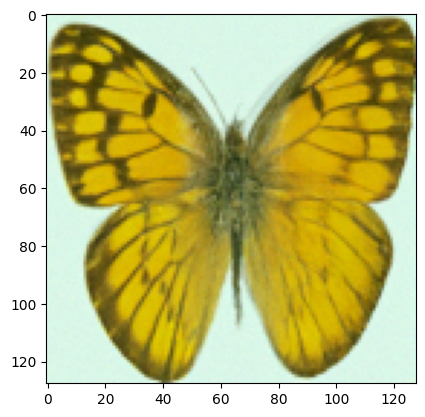

In [13]:
weights = torch.load("ddpm_model_and_scheduler.pth")
new_model = UNet2DModel(
    sample_size=img_size, 
    in_channels=3, 
    out_channels=3,
    block_out_channels=(32, 64, 128, 256, 512, 512),
    layers_per_block=2,
    down_block_types=(
        'DownBlock2D', # 128 - 64 - 32 - 16 - 8 - 4 - 2
        'DownBlock2D', 
        'DownBlock2D', 
        'DownBlock2D', 
        'AttnDownBlock2D',
        'AttnDownBlock2D'
    ),
    up_block_types=(
        'AttnUpBlock2D', 
        'AttnUpBlock2D', 
        'UpBlock2D', 
        'UpBlock2D', 
        'UpBlock2D', 
        'UpBlock2D'

    )
).to(device)
new_model.load_state_dict(weights)
pipe = DDPMPipeline(new_model, noise_scheduler)
res = pipe(num_inference_steps=1000)[0]

image = transforms.ToTensor()(res[0])
plt.imshow(image.permute(1, 2, 0))